In [27]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [28]:
splitter=transcript.time >= 24*7*3
#test_transcript=transcript[splitter].copy()
train_transcript=transcript[~splitter]

portfolio=portfolio.set_index('id')
portfolio.index.rename('offer_id', inplace=True)

dummies=portfolio.channels.apply(lambda x: pd.Series(len(x)*[1], x)).fillna(0)
portfolio=pd.concat([portfolio.drop('channels', axis=1), dummies], axis=1)
portfolio['name']=portfolio[['offer_type','reward', 'difficulty', 'duration']].astype(str).apply(','.join, axis=1)
portfolio.sort_values(['offer_type','reward','difficulty'])

,reward,difficulty,duration,offer_type,email,mobile,social,web,name
offer_id,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0,"bogo,5,5,7"
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1.0,1.0,1.0,1.0,"bogo,5,5,5"
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1.0,1.0,1.0,0.0,"bogo,10,10,7"
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1.0,1.0,1.0,1.0,"bogo,10,10,5"
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1.0,1.0,1.0,1.0,"discount,2,10,10"
2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,1.0,1.0,0.0,1.0,"discount,2,10,7"
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1.0,1.0,1.0,1.0,"discount,3,7,7"
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1.0,0.0,0.0,1.0,"discount,5,20,10"
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1.0,1.0,0.0,1.0,"informational,0,0,4"


In [29]:
profile=profile.set_index('id')
dates=profile.became_member_on.apply(lambda x: dt.strptime(str(x), '%Y%m%d'))
profile.became_member_on=dates
profile['account_age']=np.round((dt.now()-profile.became_member_on).apply(lambda x: x.days)/365)
profile.head()

,gender,age,became_member_on,income,account_age
id,,,,,
68be06ca386d4c31939f3a4f0e3dd783,None,118,2017-02-12,NaN,4.0
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,4.0
38fe809add3b4fcf9315a9694bb96ff5,None,118,2018-07-12,NaN,3.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,4.0
a03223e636434f42ac4c3df47e8bac43,None,118,2017-08-04,NaN,4.0


In [30]:
full_profile=profile.copy()
profile=profile.dropna()

In [31]:
def pull_event(event,start=0, end=24*7*4, df=transcript, parser=lambda x: x['offer id'], label='offer_id'):
    events=df[(df.event==event) & (df.time >=start) & (df.time <= end)].copy()
    events[label]=events.value.apply(parser)
    return events.drop(['value', 'event'], axis=1)

In [32]:
transactions=pull_event('transaction',df=train_transcript, parser=lambda x: x['amount'], label='spend')
transactions.set_index('person', inplace=True)
transactions.index.name='id'

number_transactions=transactions.groupby('id').time.count()
number_transactions.name='#_transactions'
spend=transactions.groupby('id').sum().spend

In [33]:
number_transactions

id
0009655768c64bdeb2e877511632db8f     2
00116118485d4dfda04fdbaba9a87b5c     3
0011e0d4e6b944f998e987f904e8c1e5     2
0020c2b971eb4e9188eac86d93036a77     4
0020ccbbb6d84e358d3414a3ff76cffd    10
                                    ..
fff3ba4757bd42088c044ca26d73817a     8
fff7576017104bcc8677a8d63322b5e1     3
fff8957ea8b240a6b5e634b6ee8eafcf     4
fffad4f4828548d1b5583907f2e9906b     8
ffff82501cea40309d5fdd7edcca4a07    11
Name: #_transactions, Length: 16058, dtype: int64

In [34]:
profile=pd.concat([profile, spend, number_transactions], 
                 axis=1).loc[profile.index].sort_values('spend', ascending=False).fillna(0)
profile['mean_spend']=(profile.spend/profile['#_transactions']).fillna(0)

In [35]:
profile_pred_dat=profile.copy()[['income', '#_transactions', 'mean_spend']]
profile_pred_dat['prop_spend']=profile.spend/profile.income
profile_pred_dat.income=profile_pred_dat.income.apply(np.log).fillna(0)

In [36]:
profile_pred_dat

,income,#_transactions,mean_spend,prop_spend
id,,,,
ae6f43089b674728a50b8727252d3305,11.170435,12.0,104.755000,0.017705
ad1f0a409ae642bc9a43f31f56c130fc,11.289782,4.0,309.080000,0.015454
dce784e26f294101999d000fad9089bb,11.608236,6.0,187.660000,0.010236
4d0ebb94a5a94fe6afd9350c7b1477e4,11.669929,6.0,182.365000,0.009352
7d7f271652d244f78b97c73cd734c553,11.492723,13.0,83.487692,0.011075
...,...,...,...,...
043b6b6be98c412d901f7f376e0548d0,11.251561,0.0,0.000000,0.000000
00e52682848542c3a6f59b7824e9a5c5,11.082143,0.0,0.000000,0.000000
25d81869d43045c09ebf32a6696908e6,11.661345,0.0,0.000000,0.000000


In [37]:
kmeans_pipe=Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4, random_state=111))
])
kmeans_pipe.fit(profile_pred_dat)
profile['cluster']=kmeans_pipe.predict(profile_pred_dat)

In [38]:
profile['prop_spend']=profile.spend/profile.income

In [39]:
profile['big_spender']=(profile.cluster==2)
profile=pd.get_dummies(profile, columns=['gender', 'cluster'])

In [40]:
train_profile=profile.drop(['became_member_on', '#_transactions','spend', 'mean_spend','prop_spend', 'gender_O'],axis=1)

In [41]:
train_profile.head()

,age,income,account_age,big_spender,gender_F,gender_M,cluster_0,cluster_1,cluster_2,cluster_3
id,,,,,,,,,,
ae6f43089b674728a50b8727252d3305,36.0,71000.0,4.0,False,1,0,0,1,0,0
ad1f0a409ae642bc9a43f31f56c130fc,66.0,80000.0,4.0,False,0,1,0,1,0,0
dce784e26f294101999d000fad9089bb,53.0,110000.0,5.0,False,1,0,0,1,0,0
4d0ebb94a5a94fe6afd9350c7b1477e4,81.0,117000.0,5.0,False,0,1,0,1,0,0
7d7f271652d244f78b97c73cd734c553,37.0,98000.0,5.0,False,0,1,0,1,0,0


In [42]:
weekly_transactions=[]
weekly_offers=[]

for week in range(0,4):
    start=week*7*24
    end=(week+1)*7*24
    transactions=pull_event('transaction',start, end, parser=lambda x: x['amount'], label='amount')
    transactions.set_index('person', inplace=True)
    transactions.index.name='id'
    weekly_transactions.append(transactions)
    
    offers_made=pull_event('offer received', start, end)
    offers_recieved=offers_made.merge(portfolio[['reward', 'difficulty', 'name']], left_on='offer_id', right_index=True)
    weekly_offers.append(offers_recieved)

In [43]:
weekly_spend=[week.groupby(level=0).sum().amount for week in weekly_transactions]
weekly_number=[week.groupby(level=0).count().amount for week in weekly_transactions]
weekly_mean=[week.groupby(level=0).mean().amount for week in weekly_transactions]

In [44]:
weekly_offer_data= [pd.get_dummies(week, columns=['name']).groupby('person').sum().drop('time',axis=1) 
                    for week in weekly_offers]

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [67]:
pipelines = [
    (('KNR', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())]))),
    (('DTR', Pipeline([('Scaler', StandardScaler()),('DTR', DecisionTreeRegressor())]))),
    (('LR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())]))),
    (('LASSO', Pipeline([('Scaler', StandardScaler()),('KNN', Lasso())]))),
    (('ELN', Pipeline([('Scaler', StandardScaler()),('DTR', ElasticNet())]))),
            ]


In [154]:
profile

,age,became_member_on,income,account_age,spend,#_transactions,mean_spend,prop_spend,big_spender,gender_F,gender_M,gender_O,cluster_0,cluster_1,cluster_2,cluster_3
id,,,,,,,,,,,,,,,,
ae6f43089b674728a50b8727252d3305,36.0,2017-05-21,71000.0,4.0,1257.06,12.0,104.755000,0.017705,False,1,0,0,0,1,0,0
ad1f0a409ae642bc9a43f31f56c130fc,66.0,2017-08-27,80000.0,4.0,1236.32,4.0,309.080000,0.015454,False,0,1,0,0,1,0,0
dce784e26f294101999d000fad9089bb,53.0,2016-02-03,110000.0,5.0,1125.96,6.0,187.660000,0.010236,False,1,0,0,0,1,0,0
4d0ebb94a5a94fe6afd9350c7b1477e4,81.0,2016-01-16,117000.0,5.0,1094.19,6.0,182.365000,0.009352,False,0,1,0,0,1,0,0
7d7f271652d244f78b97c73cd734c553,37.0,2016-03-24,98000.0,5.0,1085.34,13.0,83.487692,0.011075,False,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
043b6b6be98c412d901f7f376e0548d0,73.0,2017-10-05,77000.0,4.0,0.00,0.0,0.000000,0.000000,False,0,1,0,1,0,0,0
00e52682848542c3a6f59b7824e9a5c5,40.0,2016-10-18,65000.0,5.0,0.00,0.0,0.000000,0.000000,False,0,1,0,1,0,0,0
25d81869d43045c09ebf32a6696908e6,75.0,2017-05-29,116000.0,4.0,0.00,0.0,0.000000,0.000000,False,0,1,0,0,0,0,1


In [156]:
train_profile=profile.drop(['became_member_on', '#_transactions','spend',
                            'prop_spend','mean_spend','gender_O'],axis=1)
train_profile=profile[['age', 'income', 'account_age', 'gender_M', 'gender_F']]
#train_profile=train_profile[train_profile.big_spender==0]
#train_profile=pd.get_dummies(train_profile, columns=['account_age'])

In [157]:
test_profile=train_profile.merge(weekly_offer_data[-1], left_index=True, right_index=True, how='left').fillna(0).sort_index()
train_profile=pd.concat([train_profile.merge(week, left_index=True, right_index=True, 
                               how='left').fillna(0) for week in weekly_offer_data[:-1]]).sort_index()

In [158]:
train_spend=pd.concat([profile.merge(week, left_index=True, right_index=True, 
                               how='left').fillna(0) for week in weekly_spend[:-1]]).sort_index().amount
train_df=pd.concat([train_profile, train_spend], axis=1)
test_df=test_profile.merge(weekly_spend[-1], left_index=True, right_index=True, how='left').fillna(0).sort_index()

In [159]:
from sklearn.metrics import r2_score

In [164]:
y_base=train_df.amount

In [160]:
train_df.amount

id
0009655768c64bdeb2e877511632db8f     8.57
0009655768c64bdeb2e877511632db8f     0.00
0009655768c64bdeb2e877511632db8f    22.16
0011e0d4e6b944f998e987f904e8c1e5    11.93
0011e0d4e6b944f998e987f904e8c1e5    13.49
                                    ...  
fffad4f4828548d1b5583907f2e9906b    26.62
fffad4f4828548d1b5583907f2e9906b     8.14
ffff82501cea40309d5fdd7edcca4a07    54.08
ffff82501cea40309d5fdd7edcca4a07    96.37
ffff82501cea40309d5fdd7edcca4a07    32.36
Name: amount, Length: 44475, dtype: float64

In [169]:
X=train_df.groupby('id').mean()

In [170]:
X

,age,income,account_age,gender_M,gender_F,reward,difficulty,"name_bogo,10,10,5","name_bogo,10,10,7","name_bogo,5,5,5","name_bogo,5,5,7","name_discount,2,10,10","name_discount,2,10,7","name_discount,3,7,7","name_discount,5,20,10","name_informational,0,0,3","name_informational,0,0,4",amount
id,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,33.0,72000.0,4.0,1,0,2.333333,5.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.666667,10.243333
0011e0d4e6b944f998e987f904e8c1e5,40.0,57000.0,3.0,0,0,5.333333,13.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.666667,0.333333,0.666667,0.333333,8.473333
0020c2b971eb4e9188eac86d93036a77,59.0,90000.0,5.0,0,1,12.000000,20.000000,0.333333,0.666667,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.000000,32.776667
0020ccbbb6d84e358d3414a3ff76cffd,24.0,60000.0,5.0,0,1,7.000000,9.666667,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,45.420000
003d66b6608740288d6cc97a6903f4f0,26.0,73000.0,4.0,0,1,3.666667,16.666667,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.333333,0.333333,0.666667,10.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,69.0,83000.0,6.0,0,1,4.666667,10.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,1.000000,0.000000,57.200000
fff7576017104bcc8677a8d63322b5e1,71.0,73000.0,4.0,1,0,11.333333,16.666667,0.666667,0.333333,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,5.350000
fff8957ea8b240a6b5e634b6ee8eafcf,71.0,56000.0,3.0,1,0,0.666667,3.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,3.753333


In [167]:
scores=[]
for name,pipe in pipelines:
    X=train_df.groupby('id').mean()
    pipe.fit(X=X.iloc[:,:-1], y=X.iloc[:,-1])
    y_pred=pd.Series(pipe.predict(X=test_df.iloc[:,:-1]))
    score=r2_score(test_df.iloc[:,-1], y_pred)
    scores.append((name,score))
    print(name,score)

KNR -0.0032280151642645194
DTR -0.33523515818024063
LR 0.030901428835875988
LASSO 0.02903633382125026
ELN 0.022612426312342615


KNR


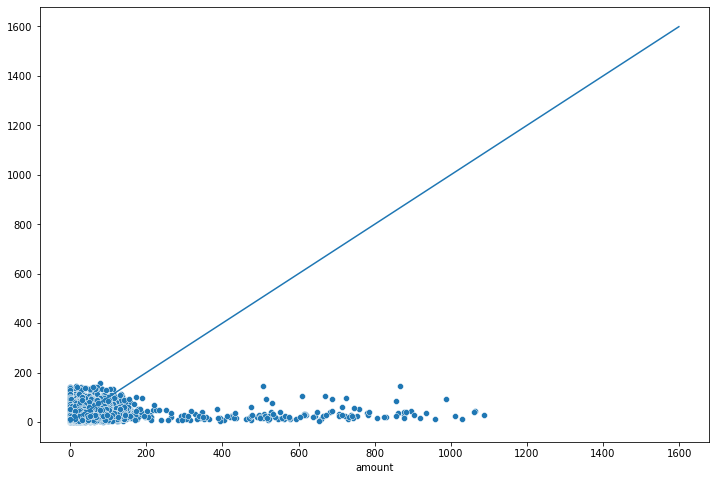

DTR


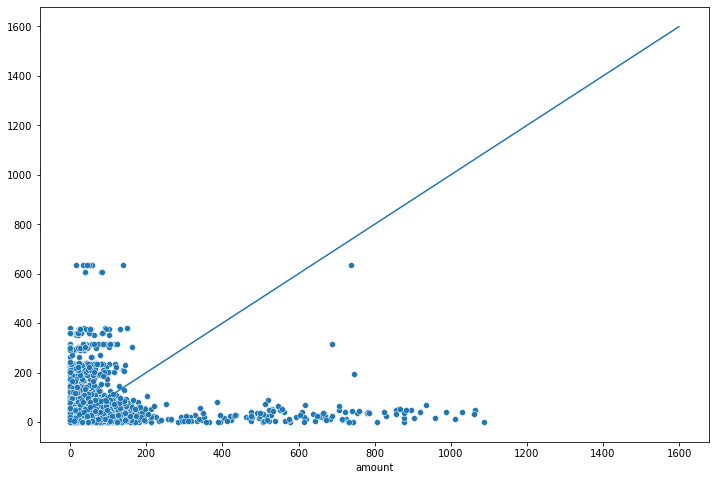

LR


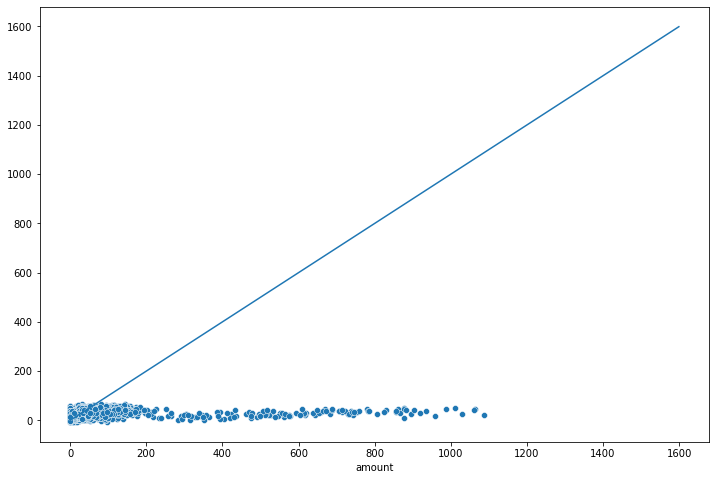

LASSO


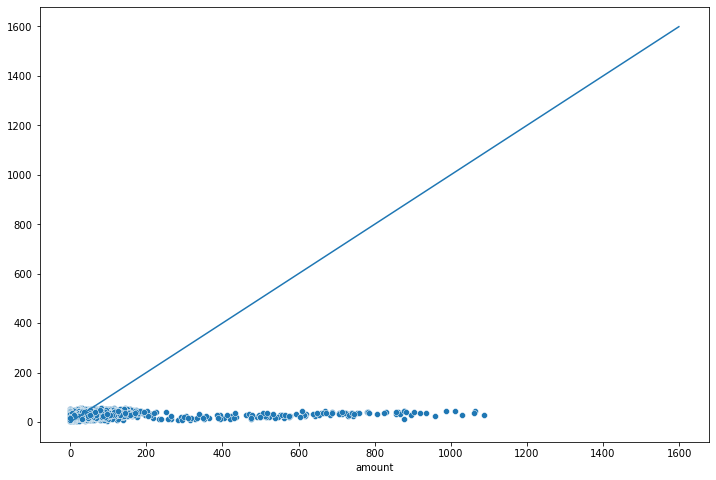

ELN


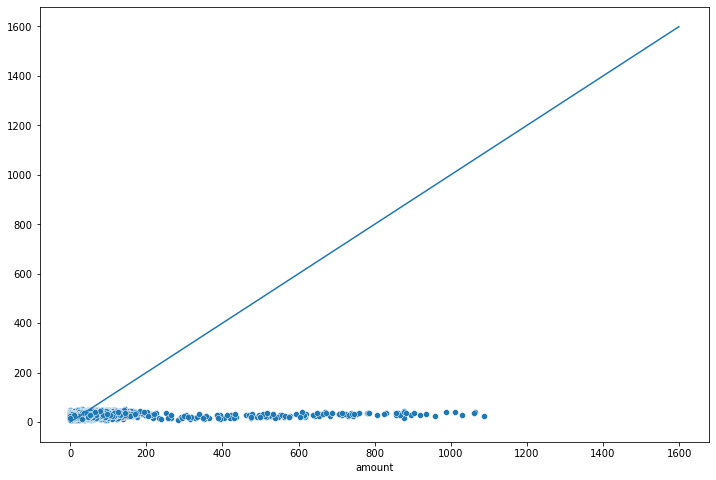

In [168]:
for name,pipe in pipelines:
    extra_test=test_df.iloc[:,:-1]
    y_pred_old=pd.Series(pipe.predict(extra_test))

    extra_test.iloc[:,-12:]=0

    y=test_df.iloc[:,-1]
    #y_pred_new=pd.Series(pipe.predict(extra_test))
    plt.subplots(figsize = (12,8))
    print(name)
    sns.scatterplot(x=y, y=y_pred_old.values);
    #sns.scatterplot(x=y, y=y_pred_new.values);
    sns.lineplot(x=range(1600), y=range(1600));
    plt.show()
    